In [1]:
import dask.dataframe as dd
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from dask.diagnostics import ProgressBar
%matplotlib inline
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from src.utils.helpers_news_movies import *
from collections import defaultdict
from scipy.sparse import csr_matrix

# Import code from other files
from src.model import model as m

/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load cosine similarity dataframes
cosine_similarity_news_df = pd.read_csv('data/df_news/cosine_similarity_news.csv')
# remove unnamed column 
cosine_similarity_news_df.drop(cosine_similarity_news_df.columns[cosine_similarity_news_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
cosine_similarity_movies_df = pd.read_csv('data/df_movies/cosine_similarity_movies.csv')

print(cosine_similarity_news_df.head())
print(cosine_similarity_movies_df.head())

themes = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']


    vietnam  cold_war  irak_war       ww2  technology   economy    health  \
0  0.153291  0.047631  0.079034  0.176376   -0.009598 -0.036335  0.018983   
1  0.078121 -0.039955  0.060634  0.018526    0.002312  0.039167  0.011849   
2  0.098636  0.101309  0.081472  0.028555    0.181080  0.131787  0.009973   
3 -0.044569  0.026489  0.078098  0.059428    0.136175  0.144368  0.073137   
4 -0.001666  0.053340  0.017597  0.049338   -0.062218 -0.034126  0.001495   

   gender_equality  migration  index  year  
0         0.044182  -0.069827      0  1992  
1        -0.009306   0.025387      1  1941  
2         0.103763   0.065460      2  1974  
3         0.148868   0.050505      3  1989  
4        -0.055145  -0.052538      4  1968  
      index   vietnam  cold_war  irak_war       ww2  technology   economy  \
0  23890098  0.089712  0.133718  0.066871  0.066404    0.084017  0.057000   
1  31186339  0.134952  0.065855  0.159707  0.089287    0.031679  0.090338   
2  20663735  0.058104  0.056550  0.0

In [12]:
# convert cosine similarity to bool with threshold of 0.3

cosine_similarity_news_df_bool = cosine_similarity_news_df.copy()
cosine_similarity_movies_df_bool = cosine_similarity_movies_df.copy()

for theme in themes:
    cosine_similarity_news_df_bool[theme] = cosine_similarity_news_df_bool[theme].apply(lambda x: 1 if x > 0.2 else 0)
    cosine_similarity_movies_df_bool[theme] = cosine_similarity_movies_df_bool[theme].apply(lambda x: 1 if x > 0.2 else 0)



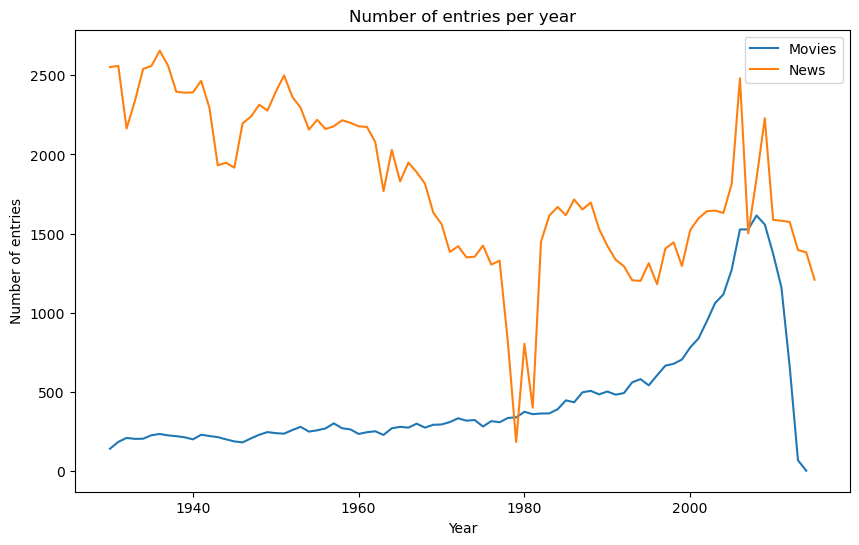

In [13]:
# Number of articles per year
movies_per_year = cosine_similarity_movies_df_bool['year'].value_counts()
news_per_year = cosine_similarity_news_df_bool['year'].value_counts()

# Sort by index
movies_per_year = movies_per_year.sort_index()
news_per_year = news_per_year.sort_index()


# Plot number of movies per year
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, label='Movies')
plt.plot(news_per_year.index, news_per_year.values, label='News')

plt.xlabel('Year')
plt.ylabel('Number of entries')
plt.title('Number of entries per year')
plt.legend()
plt.show()




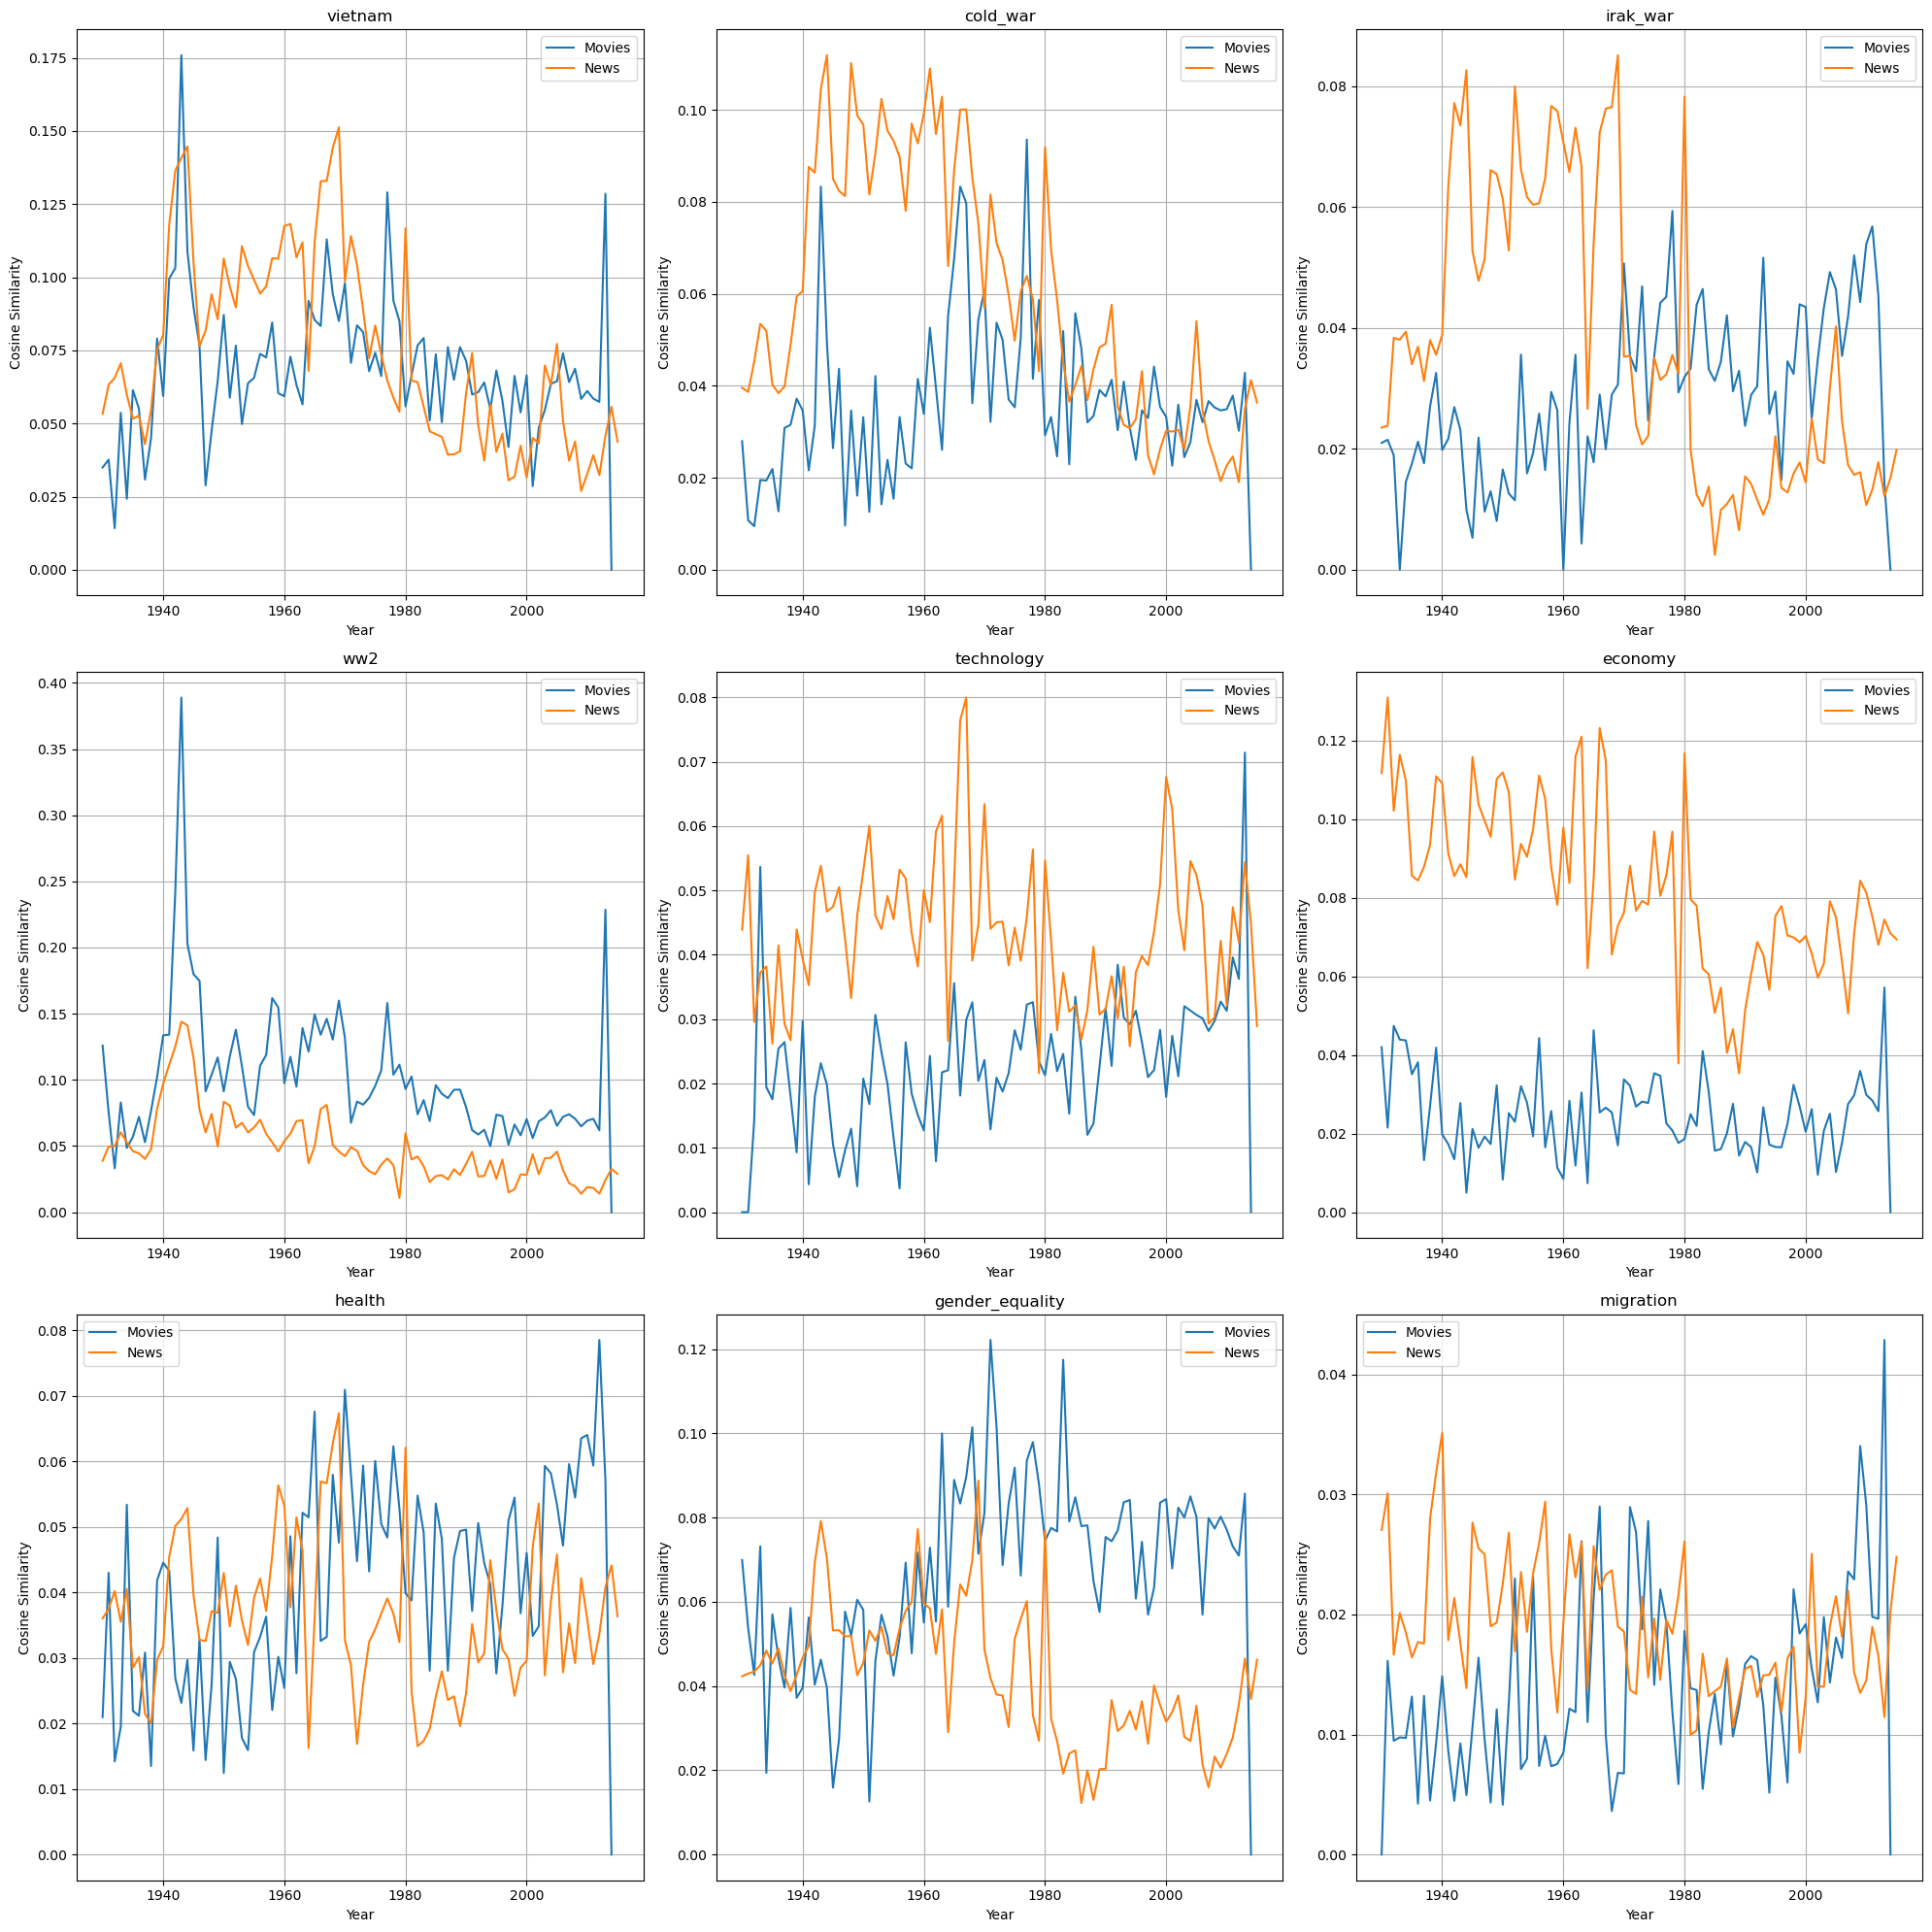

In [20]:
# Plot the cosine similarity for each query over time

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i, column in enumerate(themes):
    row = i // 3
    col = i % 3
    # Sum the boolean values for each year
    grouped_movies = cosine_similarity_movies_df_bool.groupby('year').sum()
    grouped_news = cosine_similarity_news_df_bool.groupby('year').sum()

    # Normalize the values by the number of articles in the year
    grouped_movies = grouped_movies.div(movies_per_year, axis=0)
    ax[row, col].plot(grouped_movies.index, grouped_movies[column])

    grouped_news = grouped_news.div(news_per_year, axis=0)
    ax[row, col].plot(grouped_news.index, grouped_news[column])
    ax[row, col].legend(['Movies', 'News'])
    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Cosine Similarity')
    ax[row, col].grid()


plt.tight_layout()
plt.show()
